In [1]:
from shapely.geometry import Point
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap, HeatMapWithTime
import ipywidgets as widgets
from IPython.display import HTML, display
from collections import defaultdict

In [2]:
plt.style.use('dark_background')

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

In [3]:
districts = gpd.read_file('../data/Council District Outlines (GIS).geojson')

In [4]:
districts.head()

,first_name,email_address,business_phone_number,last_name,position,council_district,geometry
0,Jonathan B.,Jonathan.Hall@nashville.gov,615-432-1301,Hall,Council Member,1,"MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ..."
1,Kyonzté,Kyonzte.Toombs@nashville.gov,615-432-1302,Toombs,Council Member,2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ..."
2,Jennifer,Jennifer.Gamble@nashville.gov,615-432-1303,Gamble,Council Member,3,"MULTIPOLYGON (((-86.76842 36.38358, -86.76824 ..."
3,Robert,Robert.Swope@nashville.gov,615-432-1304,Swope,Council Member,4,"MULTIPOLYGON (((-86.74489 36.05316, -86.74491 ..."
4,Sean,Sean.Parker@nashville.gov,615-432-1305,Parker,Council Member,5,"MULTIPOLYGON (((-86.74724 36.21041, -86.74243 ..."


In [5]:
print(districts.crs)


epsg:4326


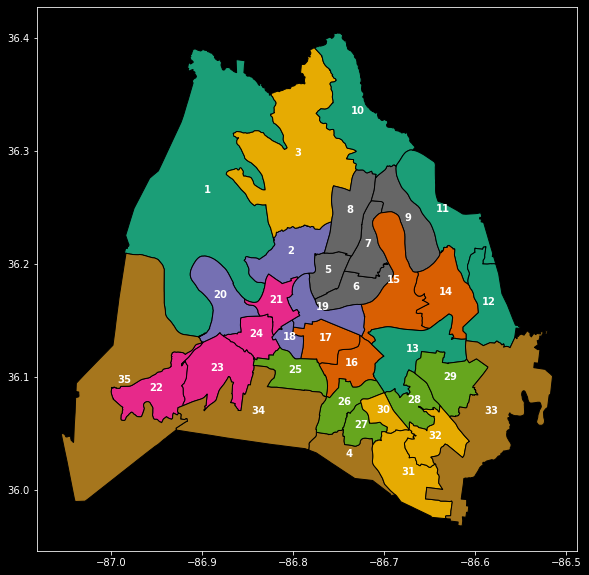

In [6]:
districts.plot(column='council_district', figsize=(10, 10),
              edgecolor = 'black', cmap='Dark2');
for index, row in districts.iterrows():
    plt.annotate(text=row['council_district'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight = 'bold')

In [7]:
building_permits = pd.read_csv('../data/Building_Permits_Issued.csv')

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
building_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33473 entries, 0 to 33472
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Permit #                    33473 non-null  object 
 1   Permit Type Description     33473 non-null  object 
 2   Permit Subtype Description  33473 non-null  object 
 3   Parcel                      33473 non-null  object 
 4   Date Entered                33473 non-null  object 
 5   Date Issued                 33473 non-null  object 
 6   Construction Cost           33471 non-null  float64
 7   Address                     33473 non-null  object 
 8   City                        33473 non-null  object 
 9   State                       33473 non-null  object 
 10  ZIP                         33473 non-null  int64  
 11  Subdivision / Lot           33473 non-null  object 
 12  Contact                     33472 non-null  object 
 13  Permit Type                 334

In [9]:
building_permits['Date Issued'] = pd.to_datetime(building_permits['Date Issued'])

In [10]:
building_permits.head(10)

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Construction Cost,Address,City,State,ZIP,Subdivision / Lot,Contact,Permit Type,Permit Subtype,IVR Tracking #,Purpose,Council District,Census Tract,Mapped Location
0,2020035848,Building Residential Rehab Storm Damage,Single Family Residence,08603001700,06/10/2020,2020-06-15,25000.0,4217 SADDLEBROOKE PL,HERMITAGE,TN,37076,LOT 15 SADDLEBROOKE,R3 CONTRACTORS LLC,CARL,CAA01R301,3833138,Repairs to roof and trusses from storm damage....,12.0,37015623.0,"4217 SADDLEBROOKE PL\nHERMITAGE, TN 37076\n(36..."
1,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,11/18/2019,2019-12-09,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,37218,LOT 49 CARRINGTON PLACE PH 5,CELEBRATION HOMES LLC,CARN,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218"
2,2020031535,Building Residential - New,Single Family Residence,174110C00500CO,05/20/2020,2020-06-15,336926.0,1724 ELIJAH RYAN DR,ANTIOCH,TN,37013,LOT 5 CANE RIDGE FARMS PH 3 SEC 2,Reyes Construction Inc,CARN,CAA01R301,3821005,"Construct single family home, 2-story, 2775 ft...",32.0,37019117.0,"1724 ELIJAH RYAN DR\nANTIOCH, TN 37013\n(36.02..."
3,2020016259,Building Residential - Rehab,Single Family Residence,160150A07000CO,03/12/2020,2020-03-12,12000.0,210 HEARTHSTONE MANOR LN,BRENTWOOD,TN,37027,UNIT 70 HEARTHSTONE MANOR CONDOMINIUM PHASE 4,ACCESS & MOBILITY INC,CARR,CAA01R301,3781961,to install a new elevator/platform lift from g...,4.0,37018803.0,"210 HEARTHSTONE MANOR LN\nBRENTWOOD, TN 37027\..."
4,2019011084,Building Use & Occupancy,"Multifamily, Townhome",051100J90000CO,02/25/2019,2019-07-22,0.0,812 BRIAR CIR,MADISON,TN,37115,COMMON AREA HOMES AT BRIAR,COLE INVESTMENTS LLC,CAUO,CAA03R301,3611315,MASTER PERMIT ONLY� � NO CONSTRUCTION� �MULTI-...,8.0,37010802.0,"812 BRIAR CIR\nMADISON, TN 37115"
5,2019041868,Building Demolition Permit,Demolition Permit - Residential,09112014600,07/15/2019,2019-07-22,10000.0,4400 DELAWARE AVE,NASHVILLE,TN,37209,LOTS 301 & 303 BLK 38 W NASH PLAN NO 1,BUILD NASHVILLE LLC,CADM,CAZ01A001,3691130,to demolish exiting single family residence. n...,20.0,37013300.0,"4400 DELAWARE AVE\nNASHVILLE, TN 37209\n(36.15..."
6,2019043169,Building Use & Occupancy,"Accessory Structure, Pools - Residential",03900024200,07/22/2019,2019-07-22,5600.0,6341 OLD HICKORY BLVD,WHITES CREEK,TN,37189,LOT 2 DENNY SUB,Janet Denny,CAUO,CAA14U017,3693166,to construct 24' round above ground pool to th...,1.0,37010104.0,"6341 OLD HICKORY BLVD\nWHITES CREEK, TN 37189\..."
7,2019042869,Building Demolition Permit,Demo Permit - Residential Accessory,17300001800,07/19/2019,2019-07-22,23816.0,14421 OLD HICKORY BLVD,ANTIOCH,TN,37013,W/S OLD HICKORY BV N OF BARNES RD,BELLUS CONSTRUCTION CORP,CADM,CAZ01A003,3692670,Work on this demolition permit must commence w...,31.0,37019112.0,"14421 OLD HICKORY BLVD\nANTIOCH, TN 37013\n(36..."
8,2019043157,Building Residential - Rehab,Single Family Residence,181070A05400CO,07/22/2019,2019-07-22,20000.0,9405 KAPLAN AVE,BRENTWOOD,TN,37027,LOT 54 AUTUMN VIEW PH 1,SHAW CONSTRUCTION,CARR,CAA01R301,3693150,Repairs to single family residence due to tree...,31.0,37019114.0,"9405 KAPLAN AVE\nBRENTWOOD, TN 37027"
9,2019042679,Building Commercial - Rehab,Hotel / Motel,09310048700,07/18/2019,2019-07-22,15000.0,201 8TH AVE S,NASHVILLE,TN,37203,LOT 1 CLARK PLACE RESUB REV 2,RICHEY RESTORATIONS INC,CACR,CAF14R102,3692368,Emergency Service Repairs to hotel due to wate...,19.0,37019500.0,"201 8TH AVE S\nNASHVILLE, TN 37203\n(36.15658,..."


In [11]:
points = []
for row in building_permits['Mapped Location']:
    #split by new lines get last split, replace any parens, split on commas
    position = row.split('\n')[-1].replace('(', '').replace(')', '').split(',')
    try:
        # Build a point if we can
        points.append(Point(float(position[1]), float(position[0])))
    except: 
        # If we can't build a point, put a null
        points.append(np.NaN)
        

In [12]:
building_permits['position'] = points

In [13]:
building_permits.head()

,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Construction Cost,Address,City,State,...,Subdivision / Lot,Contact,Permit Type,Permit Subtype,IVR Tracking #,Purpose,Council District,Census Tract,Mapped Location,position
0,2020035848,Building Residential Rehab Storm Damage,Single Family Residence,08603001700,06/10/2020,2020-06-15,25000.0,4217 SADDLEBROOKE PL,HERMITAGE,TN,...,LOT 15 SADDLEBROOKE,R3 CONTRACTORS LLC,CARL,CAA01R301,3833138,Repairs to roof and trusses from storm damage....,12.0,37015623.0,"4217 SADDLEBROOKE PL\nHERMITAGE, TN 37076\n(36...",POINT (-86.601445 36.191328)
1,2019070460,Building Residential - New,Single Family Residence,058100C04900CO,11/18/2019,2019-12-09,270585.0,1037 LAWSONS RIDGE DR,NASHVILLE,TN,...,LOT 49 CARRINGTON PLACE PH 5,CELEBRATION HOMES LLC,CARN,CAA01R301,3733056,To construct a single family residence of 2402...,1.0,37010105.0,"1037 LAWSONS RIDGE DR\nNASHVILLE, TN 37218",NaN
2,2020031535,Building Residential - New,Single Family Residence,174110C00500CO,05/20/2020,2020-06-15,336926.0,1724 ELIJAH RYAN DR,ANTIOCH,TN,...,LOT 5 CANE RIDGE FARMS PH 3 SEC 2,Reyes Construction Inc,CARN,CAA01R301,3821005,"Construct single family home, 2-story, 2775 ft...",32.0,37019117.0,"1724 ELIJAH RYAN DR\nANTIOCH, TN 37013\n(36.02...",POINT (-86.647436 36.022205)
3,2020016259,Building Residential - Rehab,Single Family Residence,160150A07000CO,03/12/2020,2020-03-12,12000.0,210 HEARTHSTONE MANOR LN,BRENTWOOD,TN,...,UNIT 70 HEARTHSTONE MANOR CONDOMINIUM PHASE 4,ACCESS & MOBILITY INC,CARR,CAA01R301,3781961,to install a new elevator/platform lift from g...,4.0,37018803.0,"210 HEARTHSTONE MANOR LN\nBRENTWOOD, TN 37027\...",POINT (-86.764816 36.042219)
4,2019011084,Building Use & Occupancy,"Multifamily, Townhome",051100J90000CO,02/25/2019,2019-07-22,0.0,812 BRIAR CIR,MADISON,TN,...,COMMON AREA HOMES AT BRIAR,COLE INVESTMENTS LLC,CAUO,CAA03R301,3611315,MASTER PERMIT ONLY� � NO CONSTRUCTION� �MULTI-...,8.0,37010802.0,"812 BRIAR CIR\nMADISON, TN 37115",NaN


In [14]:
built_permits_geo = gpd.GeoDataFrame(building_permits, crs=districts.crs, geometry=building_permits['position'])

In [15]:
built_permits_geo.columns

Index(['Permit #', 'Permit Type Description', 'Permit Subtype Description',
       'Parcel', 'Date Entered', 'Date Issued', 'Construction Cost', 'Address',
       'City', 'State', 'ZIP', 'Subdivision / Lot', 'Contact', 'Permit Type',
       'Permit Subtype', 'IVR Tracking #', 'Purpose', 'Council District',
       'Census Tract', 'Mapped Location', 'position', 'geometry'],
      dtype='object')

In [16]:
permits_by_district = gpd.sjoin(built_permits_geo, districts, op='within')

In [17]:
permits_by_district.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28928 entries, 0 to 33347
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Permit #                    28928 non-null  object        
 1   Permit Type Description     28928 non-null  object        
 2   Permit Subtype Description  28928 non-null  object        
 3   Parcel                      28928 non-null  object        
 4   Date Entered                28928 non-null  object        
 5   Date Issued                 28928 non-null  datetime64[ns]
 6   Construction Cost           28926 non-null  float64       
 7   Address                     28928 non-null  object        
 8   City                        28928 non-null  object        
 9   State                       28928 non-null  object        
 10  ZIP                         28928 non-null  int64         
 11  Subdivision / Lot           28928 non-null  ob

In [18]:
print(permits_by_district['Date Issued'].min())
print(permits_by_district['Date Issued'].max())

2017-09-20 00:00:00
2020-09-23 00:00:00


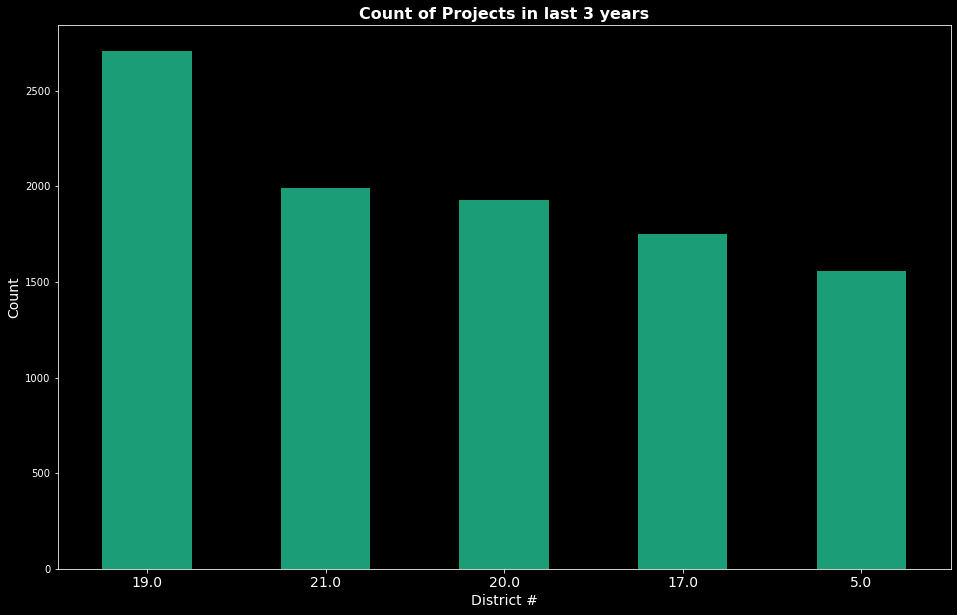

In [19]:
permits_by_district['Council District'].value_counts()[:5].plot(kind='bar', figsize=(16,10), cmap='Dark2')
plt.xticks(rotation = 0, fontsize = 14)
plt.xlabel('District #', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Count of Projects in last 3 years', fontsize = 16, fontweight = 'bold');

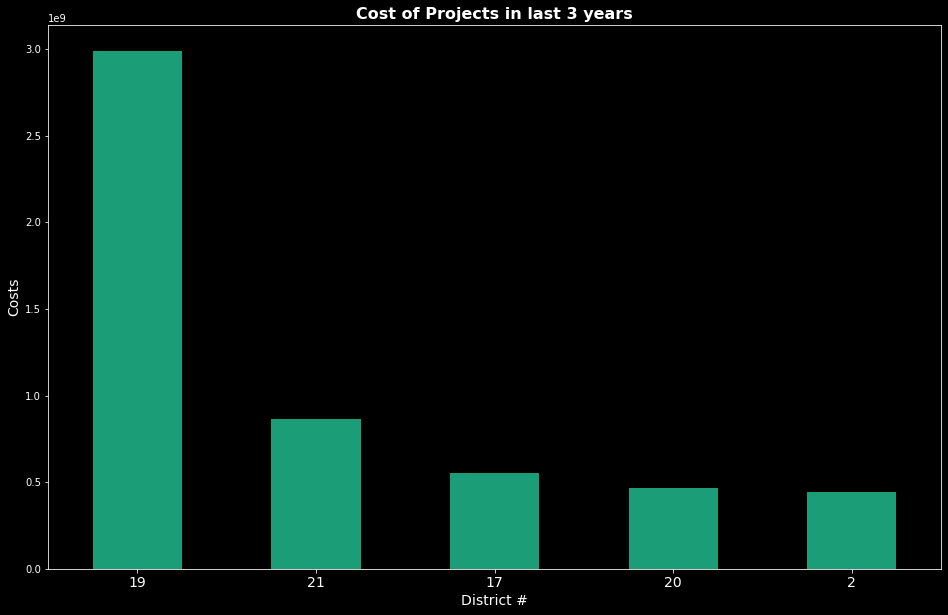

In [20]:
permits_by_district.groupby('council_district')['Construction Cost'].sum().sort_values(ascending=False)[:5].plot(kind='bar', figsize=(16,10), cmap='Dark2')
plt.xticks(rotation = 0, fontsize = 14)
plt.xlabel('District #', fontsize = 14)
plt.ylabel('Costs', fontsize = 14)
plt.title('Cost of Projects in last 3 years', fontsize = 16, fontweight = 'bold');

In [21]:
district19 = districts.loc[districts['council_district']=='19']

In [22]:
center = [district19.centroid.y, district19.centroid.x]

<ipython-input-22-ae83177786b6>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [district19.centroid.y, district19.centroid.x]


In [23]:
%%html
<style>
.box_style {
    width:75%;
    height: auto;
    color: white; 
}
.widget-readout {
        color: white; 
}
</style>

In [24]:
years = widgets.IntRangeSlider(min=permits_by_district['Date Issued'].min().year, max=permits_by_district['Date Issued'].max().year, step=1, value=(2020,2020))
years.add_class('box_style')

IntRangeSlider(value=(2020, 2020), max=2020, min=2017, _dom_classes=('box_style',))

In [25]:
districts_list = sorted(permits_by_district['council_district'].unique().tolist())
districts_select = widgets.SelectMultiple(
    options=districts_list,
    value=districts_list,
    #rows=10,
    description='Council Districts',
    disabled=False
)
display(districts_select)

SelectMultiple(description='Council Districts', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…

In [26]:
@widgets.interact(years_filter=years, districts_filter=districts_select)
def project_map(years_filter, districts_filter):
    nashmap = folium.Map(location=center, zoom_start=10.5)
    folium.GeoJson(districts).add_to(nashmap)
    marker_cluster = MarkerCluster().add_to(nashmap)
    mask = (
        (permits_by_district['Date Issued'].dt.year.isin(years_filter)) & 
        (permits_by_district['council_district'].isin(districts_filter)) &
        (permits_by_district['geometry'].notnull())
    )
    pb = widgets.FloatProgress(
            value=0,
            min=0,
            max=100,
            step=0.01,
            description='Loading:',
            bar_style='info',
            orientation='horizontal'
        )
    display(pb)
    counter = 0
    for idx, row in permits_by_district.loc[mask].iterrows():
        counter += 1
        pb.value = ((counter+1) / permits_by_district.loc[mask].shape[0]) * 100
        loc = [row['geometry'].y, row['geometry'].x]
    #     print(loc)
        pop = f"""<h2>Permit: {row['Permit #']}</h2><br>
                  Type: {row['Permit Type Description']}<br>
                  Costs: {row['Construction Cost']}<br>
                  Date Issued: {row['Date Issued'].month_name} {row['Date Issued'].day} {row['Date Issued'].year}<br>
                  District: {row['Council District']}"""
        marker = folium.Marker(
            location = loc, 
            popup = pop)
        marker.add_to(marker_cluster)
    pb.layout.visibility = None
    return nashmap

interactive(children=(IntRangeSlider(value=(2020, 2020), description='years_filter', max=2020, min=2017, _dom_…

In [27]:
cost_by_district = permits_by_district.groupby('council_district')['Construction Cost'].sum().reset_index()

In [28]:
cost_by_district

,council_district,Construction Cost
0,1,4.165454e+07
1,10,5.068945e+07
2,11,1.069060e+08
3,12,6.875763e+07
4,13,3.728272e+08
5,14,1.269671e+08
6,15,2.012435e+08
7,16,1.088687e+08
8,17,5.543216e+08
9,18,4.408251e+08


# How about construction cost per district?

In [29]:
cost_by_district = districts.merge(cost_by_district, on='council_district')

In [30]:
cost_by_district_geo = gpd.GeoDataFrame(cost_by_district, crs=districts.crs, geometry=cost_by_district['geometry'])

In [31]:
def mathplotlib_chloro():
    cost_by_district_geo.plot(column='Construction Cost',figsize=(20, 20),
                  edgecolor = 'black', cmap='Dark2');
    for index, row in cost_by_district_geo.iterrows():
        cost_mil = round(row['Construction Cost'] / 1000000, 0)
        plt.annotate(text=f'{cost_mil}M', 
                     xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', fontweight = 'bold')

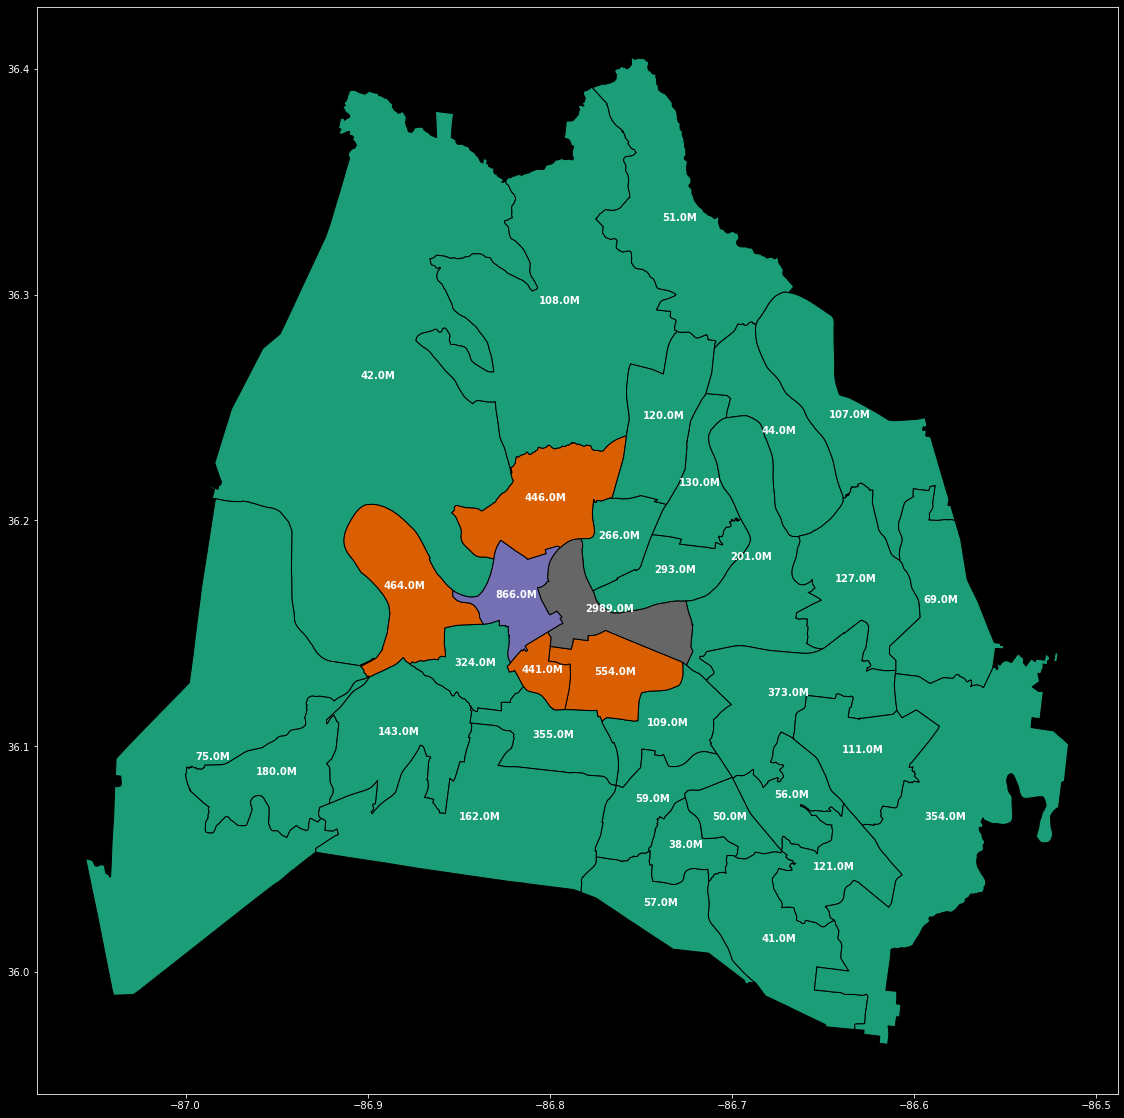

In [32]:
mathplotlib_chloro()

In [33]:
def folium_chloro():
    bins = list(cost_by_district['Construction Cost'].quantile([0, 0.25, 0.5, 0.75, 1]))
    nashmapcost = folium.Map(location=center, zoom_start=10.5)
    folium.Choropleth(
        geo_data=districts, 
        data=cost_by_district, 
        columns=['council_district', 'Construction Cost'], 
        key_on='feature.id',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Construction Costs',
        nan_fill_color='lightgreen',
        bins=bins,
        reset=True
    ).add_to(nashmapcost)
    return nashmapcost

In [34]:
folium_chloro()

In [35]:
def render_heatmap():
    nashmapheat = folium.Map(location=center, zoom_start=10.5)
    heatmapdata = [
        (point.y, point.x) for point 
            in built_permits_geo[built_permits_geo['Date Issued'].dt.year==2020]['geometry'] 
                if point
    ]
    # print(heatmapdata)
    hm = HeatMap(data=heatmapdata)
    hm.add_to(nashmapheat)
    return nashmapheat

In [36]:
render_heatmap()

In [37]:
data_points = [
    (row['Date Issued'].to_pydatetime(), row['geometry'].y, row['geometry'].x) 
        for idx, row in built_permits_geo.sort_values('Date Issued').iterrows() 
            if row['geometry']
]

by_month=defaultdict(list)
for record in data_points:
    by_month[f'{record[0].strftime("%Y-%m")}'].append([record[1],record[2], 1])
    
over_time = []
time_index = []
for key, values in by_month.items():
    over_time.append(values)
    time_index.append(key)

In [38]:
def render_over_time():
    nashmapheattime = folium.Map(location=center, zoom_start=10.5)
    hm = HeatMapWithTime(data=over_time,
        index=time_index,
        auto_play=False,
        max_opacity=0.3)
    hm.add_to(nashmapheattime)
    return nashmapheattime

In [39]:
render_over_time()